In [200]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import scipy.stats
from scipy import stats, optimize

def IntervalGen(df, _type):
    x = []
    if _type == 'start':
        for i in range(0, len(df)):
            x.append(df.iloc[i].started_at[11:19])
    else:
        for i in range(0, len(df)):
            x.append(df.iloc[i].ended_at[11:19])
    return(x)

def TimeInterval(_list):
    deltaT = []
    time_intervals = []
    FMT = '%H:%M:%S'
    for i in range(0,len(_list)-1):
        deltaT.append(datetime.strptime(_list[i+1], FMT) - datetime.strptime(_list[i], FMT))
    for s in deltaT:
        time_intervals.append(s.seconds)
    return(time_intervals)

def gen_t(_lambda):
    r = np.random.uniform()
    return -np.log(1-r)/_lambda

In [118]:
#Citibike Data from April 2022 saved into Dataframe
df = pd.read_csv('citibike_may9.csv')
df.head()

C:\Users\eddie\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (5,7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,2E89F1D88B8347E6,classic_bike,2022-04-08 19:50:00,2022-04-08 19:55:28,E 89 St & 3 Ave,7265.10,Madison Ave & E 99 St,7443.01,40.780628,-73.952167,40.789485,-73.952429,member
1,43F6D61DFEDAE4AF,electric_bike,2022-04-27 10:19:54,2022-04-27 10:33:29,Broadway & W 29 St,6289.06,Broadway & W 29 St,6289.06,40.746201,-73.988557,40.746201,-73.988557,member
2,21C7076071104314,classic_bike,2022-04-28 13:10:59,2022-04-28 13:17:18,E 123 St & Lexington Ave,7636.05,E 123 St & Lexington Ave,7636.05,40.802926,-73.937900,40.802926,-73.937900,member
3,7D7CEA2953427D0C,classic_bike,2022-04-13 20:21:18,2022-04-13 20:37:28,W 36 St & 9 Ave,6569.07,W 36 St & 9 Ave,6569.07,40.754623,-73.995168,40.754623,-73.995168,member
4,AD7E176748A4A55E,electric_bike,2022-04-29 18:56:24,2022-04-29 18:57:16,Graham Ave & Withers St,5403.04,Graham Ave & Withers St,5403.04,40.716981,-73.944859,40.716981,-73.944859,member


In [119]:
#Filtering unwanted columns -- dropping rows w/ values N/A
df1 = df.drop(['ride_id','start_station_id','end_station_id','start_lat','start_lng','end_lat','end_lng','member_casual','rideable_type'], axis = 1).dropna()

df1.head()

,started_at,ended_at,start_station_name,end_station_name
0,2022-04-08 19:50:00,2022-04-08 19:55:28,E 89 St & 3 Ave,Madison Ave & E 99 St
1,2022-04-27 10:19:54,2022-04-27 10:33:29,Broadway & W 29 St,Broadway & W 29 St
2,2022-04-28 13:10:59,2022-04-28 13:17:18,E 123 St & Lexington Ave,E 123 St & Lexington Ave
3,2022-04-13 20:21:18,2022-04-13 20:37:28,W 36 St & 9 Ave,W 36 St & 9 Ave
4,2022-04-29 18:56:24,2022-04-29 18:57:16,Graham Ave & Withers St,Graham Ave & Withers St


In [120]:
#Verifying integrity of data
#Checking if bikes rented = bikes returned
print('Bikes Rented = Bikes Returned: ', bool(np.sum(df1['start_station_name'].value_counts()) == np.sum(df1['end_station_name'].value_counts())))

Bikes Rented = Bikes Returned:  True


In [121]:
#Identifying all stations in Central Park
is_cpark = df1['start_station_name'].str.contains('Central Park')
df1['start_station_name'][is_cpark].value_counts()

Central Park S & 6 Ave                           8730
Grand Army Plaza & Central Park S                7236
7 Ave & Central Park South                       7122
Central Park West & W 72 St                      6881
Central Park West & W 68 St                      6163
Central Park West & W 85 St                      5059
Central Park W & W 91 St                         4732
Central Park North & Adam Clayton Powell Blvd    4544
Central Park West & W 76 St                      3908
W 106 St & Central Park West                     3095
Central Park W & W 97 St                         2948
W 82 St & Central Park West                      2776
Central Park W & W 103 St                        2701
Name: start_station_name, dtype: int64

In [122]:
#Filtering for Start data in Central Park S & 6 Ave
is_cpark6_start = df1['start_station_name'].str.contains('Central Park S & 6 Ave')
dfStart = df1[is_cpark6_start]

dfStart = dfStart.drop(['ended_at','end_station_name'],axis = 1)
dfStart = dfStart.sort_values(['started_at'], ascending = True)
dfStart

,started_at,start_station_name
826756,2022-04-01 07:02:48,Central Park S & 6 Ave
53926,2022-04-01 07:12:01,Central Park S & 6 Ave
265261,2022-04-01 07:14:59,Central Park S & 6 Ave
273424,2022-04-01 07:15:24,Central Park S & 6 Ave
562886,2022-04-01 07:36:44,Central Park S & 6 Ave
...,...,...
1500966,2022-04-30 22:30:26,Central Park S & 6 Ave
260674,2022-04-30 22:52:16,Central Park S & 6 Ave
599207,2022-04-30 23:09:41,Central Park S & 6 Ave
1489537,2022-04-30 23:36:54,Central Park S & 6 Ave


In [123]:
#Filtering for End data in Central Park S & 6 Ave
is_cpark6_end = df1['end_station_name'].str.contains('Central Park S & 6 Ave')
dfEnd = df1[is_cpark6_end]

dfEnd = dfEnd.drop(['started_at','start_station_name'],axis = 1)
dfEnd = dfEnd.sort_values(['ended_at'], ascending = True)
dfEnd

,ended_at,end_station_name
2266058,2022-04-01 01:28:52,Central Park S & 6 Ave
2277024,2022-04-01 01:51:13,Central Park S & 6 Ave
2260817,2022-04-01 03:26:45,Central Park S & 6 Ave
2274208,2022-04-01 06:47:14,Central Park S & 6 Ave
2259096,2022-04-01 07:20:27,Central Park S & 6 Ave
...,...,...
2261873,2022-04-30 22:29:31,Central Park S & 6 Ave
2269453,2022-04-30 22:35:40,Central Park S & 6 Ave
2274695,2022-04-30 22:53:12,Central Park S & 6 Ave
2277702,2022-04-30 23:03:58,Central Park S & 6 Ave


In [171]:
#The following are the weekend days in april: 2,3,9,10,16,17,23,24,30

#Customer Arrivals on weekends from 12pm - 4pm
    #April 2 - 12-4pm
april2_start12 = dfStart[dfStart['started_at'].str.contains('2022-04-02 12:')]
april2_start13 = dfStart[dfStart['started_at'].str.contains('2022-04-02 13:')]
april2_start14 = dfStart[dfStart['started_at'].str.contains('2022-04-02 14:')]
april2_start15 = dfStart[dfStart['started_at'].str.contains('2022-04-02 15:')]
april2_start16 = dfStart[dfStart['started_at'].str.contains('2022-04-02 16:')]
april2_start = pd.concat([april2_start12, april2_start13, april2_start14, april2_start15, april2_start16], axis=0)

    #April 3 - 12-4pm
april3_start12 = dfStart[dfStart['started_at'].str.contains('2022-04-03 12:')]
april3_start13 = dfStart[dfStart['started_at'].str.contains('2022-04-03 13:')]
april3_start14 = dfStart[dfStart['started_at'].str.contains('2022-04-03 14:')]
april3_start15 = dfStart[dfStart['started_at'].str.contains('2022-04-03 15:')]
april3_start16 = dfStart[dfStart['started_at'].str.contains('2022-04-03 16:')]
april3_start = pd.concat([april3_start12, april3_start13, april3_start14, april3_start15, april3_start16], axis=0)

    #April 9 - 12-4pm
april9_start12 = dfStart[dfStart['started_at'].str.contains('2022-04-09 12:')]
april9_start13 = dfStart[dfStart['started_at'].str.contains('2022-04-09 13:')]
april9_start14 = dfStart[dfStart['started_at'].str.contains('2022-04-09 14:')]
april9_start15 = dfStart[dfStart['started_at'].str.contains('2022-04-09 15:')]
april9_start16 = dfStart[dfStart['started_at'].str.contains('2022-04-09 16:')]
april9_start = pd.concat([april9_start12, april9_start13, april9_start14, april9_start15, april9_start16], axis=0)

    #April 10 - 12-4pm
april10_start12 = dfStart[dfStart['started_at'].str.contains('2022-04-10 12:')]
april10_start13 = dfStart[dfStart['started_at'].str.contains('2022-04-10 13:')]
april10_start14 = dfStart[dfStart['started_at'].str.contains('2022-04-10 14:')]
april10_start15 = dfStart[dfStart['started_at'].str.contains('2022-04-10 15:')]
april10_start16 = dfStart[dfStart['started_at'].str.contains('2022-04-10 16:')]
april10_start = pd.concat([april10_start12, april10_start13, april10_start14, april10_start15, april10_start16], axis=0)

    #April 16 - 12-4pm
april16_start12 = dfStart[dfStart['started_at'].str.contains('2022-04-16 12:')]
april16_start13 = dfStart[dfStart['started_at'].str.contains('2022-04-16 13:')]
april16_start14 = dfStart[dfStart['started_at'].str.contains('2022-04-16 14:')]
april16_start15 = dfStart[dfStart['started_at'].str.contains('2022-04-16 15:')]
april16_start16 = dfStart[dfStart['started_at'].str.contains('2022-04-16 16:')]
april16_start = pd.concat([april16_start12, april16_start13, april16_start14, april16_start15, april16_start16], axis=0)

    #April 17 - 12-4pm
april17_start12 = dfStart[dfStart['started_at'].str.contains('2022-04-17 12:')]
april17_start13 = dfStart[dfStart['started_at'].str.contains('2022-04-17 13:')]
april17_start14 = dfStart[dfStart['started_at'].str.contains('2022-04-17 14:')]
april17_start15 = dfStart[dfStart['started_at'].str.contains('2022-04-17 15:')]
april17_start16 = dfStart[dfStart['started_at'].str.contains('2022-04-17 16:')]
april17_start = pd.concat([april17_start12, april17_start13, april17_start14, april17_start15, april17_start16], axis=0)

    #April 23 - 12-4pm
april23_start12 = dfStart[dfStart['started_at'].str.contains('2022-04-23 12:')]
april23_start13 = dfStart[dfStart['started_at'].str.contains('2022-04-23 13:')]
april23_start14 = dfStart[dfStart['started_at'].str.contains('2022-04-23 14:')]
april23_start15 = dfStart[dfStart['started_at'].str.contains('2022-04-23 15:')]
april23_start16 = dfStart[dfStart['started_at'].str.contains('2022-04-23 16:')]
april23_start = pd.concat([april23_start12, april23_start13, april23_start14, april23_start15, april23_start16], axis=0)

    #April 24 - 12-4pm
april24_start12 = dfStart[dfStart['started_at'].str.contains('2022-04-24 12:')]
april24_start13 = dfStart[dfStart['started_at'].str.contains('2022-04-24 13:')]
april24_start14 = dfStart[dfStart['started_at'].str.contains('2022-04-24 14:')]
april24_start15 = dfStart[dfStart['started_at'].str.contains('2022-04-24 15:')]
april24_start16 = dfStart[dfStart['started_at'].str.contains('2022-04-24 16:')]
april24_start = pd.concat([april24_start12, april24_start13, april24_start14, april24_start15, april24_start16], axis=0)

    #April 30 - 12-4pm
april30_start12 = dfStart[dfStart['started_at'].str.contains('2022-04-30 12:')]
april30_start13 = dfStart[dfStart['started_at'].str.contains('2022-04-30 13:')]
april30_start14 = dfStart[dfStart['started_at'].str.contains('2022-04-30 14:')]
april30_start15 = dfStart[dfStart['started_at'].str.contains('2022-04-30 15:')]
april30_start16 = dfStart[dfStart['started_at'].str.contains('2022-04-30 16:')]
april30_start = pd.concat([april30_start12, april30_start13, april30_start14, april30_start15, april30_start16], axis=0)

#####################################################################################

#Customer Returns on weekends from 12pm - 4pm
    #April 2 - 12-4pm
april2_end12 = dfEnd[dfEnd['ended_at'].str.contains('2022-04-02 12:')]
april2_end13 = dfEnd[dfEnd['ended_at'].str.contains('2022-04-02 13:')]
april2_end14 = dfEnd[dfEnd['ended_at'].str.contains('2022-04-02 14:')]
april2_end15 = dfEnd[dfEnd['ended_at'].str.contains('2022-04-02 15:')]
april2_end16 = dfEnd[dfEnd['ended_at'].str.contains('2022-04-02 16:')]
april2_end = pd.concat([april2_end12, april2_end13, april2_end14, april2_end15, april2_end16], axis=0)

    #April 3 - 12-4pm
april3_end12 = dfEnd[dfEnd['ended_at'].str.contains('2022-04-03 12:')]
april3_end13 = dfEnd[dfEnd['ended_at'].str.contains('2022-04-03 13:')]
april3_end14 = dfEnd[dfEnd['ended_at'].str.contains('2022-04-03 14:')]
april3_end15 = dfEnd[dfEnd['ended_at'].str.contains('2022-04-03 15:')]
april3_end16 = dfEnd[dfEnd['ended_at'].str.contains('2022-04-03 16:')]
april3_end = pd.concat([april3_end12, april3_end13, april3_end14, april3_end15, april3_end16], axis=0)

    #April 9 - 12-4pm
april9_end12 = dfEnd[dfEnd['ended_at'].str.contains('2022-04-09 12:')]
april9_end13 = dfEnd[dfEnd['ended_at'].str.contains('2022-04-09 13:')]
april9_end14 = dfEnd[dfEnd['ended_at'].str.contains('2022-04-09 14:')]
april9_end15 = dfEnd[dfEnd['ended_at'].str.contains('2022-04-09 15:')]
april9_end16 = dfEnd[dfEnd['ended_at'].str.contains('2022-04-09 16:')]
april9_end = pd.concat([april9_end12, april9_end13, april9_end14, april9_end15, april9_end16], axis=0)

    #April 10 - 12-4pm
april10_end12 = dfEnd[dfEnd['ended_at'].str.contains('2022-04-10 12:')]
april10_end13 = dfEnd[dfEnd['ended_at'].str.contains('2022-04-10 13:')]
april10_end14 = dfEnd[dfEnd['ended_at'].str.contains('2022-04-10 14:')]
april10_end15 = dfEnd[dfEnd['ended_at'].str.contains('2022-04-10 15:')]
april10_end16 = dfEnd[dfEnd['ended_at'].str.contains('2022-04-10 16:')]
april10_end = pd.concat([april10_end12, april10_end13, april10_end14, april10_end15, april10_end16], axis=0)

    #April 16 - 12-4pm
april16_end12 = dfEnd[dfEnd['ended_at'].str.contains('2022-04-16 12:')]
april16_end13 = dfEnd[dfEnd['ended_at'].str.contains('2022-04-16 13:')]
april16_end14 = dfEnd[dfEnd['ended_at'].str.contains('2022-04-16 14:')]
april16_end15 = dfEnd[dfEnd['ended_at'].str.contains('2022-04-16 15:')]
april16_end16 = dfEnd[dfEnd['ended_at'].str.contains('2022-04-16 16:')]
april16_end = pd.concat([april16_end12, april16_end13, april16_end14, april16_end15, april16_end16], axis=0)

    #April 17 - 12-4pm
april17_end12 = dfEnd[dfEnd['ended_at'].str.contains('2022-04-17 12:')]
april17_end13 = dfEnd[dfEnd['ended_at'].str.contains('2022-04-17 13:')]
april17_end14 = dfEnd[dfEnd['ended_at'].str.contains('2022-04-17 14:')]
april17_end15 = dfEnd[dfEnd['ended_at'].str.contains('2022-04-17 15:')]
april17_end16 = dfEnd[dfEnd['ended_at'].str.contains('2022-04-17 16:')]
april17_end = pd.concat([april17_end12, april17_end13, april17_end14, april17_end15, april17_end16], axis=0)

    #April 23 - 12-4pm
april23_end12 = dfEnd[dfEnd['ended_at'].str.contains('2022-04-23 12:')]
april23_end13 = dfEnd[dfEnd['ended_at'].str.contains('2022-04-23 13:')]
april23_end14 = dfEnd[dfEnd['ended_at'].str.contains('2022-04-23 14:')]
april23_end15 = dfEnd[dfEnd['ended_at'].str.contains('2022-04-23 15:')]
april23_end16 = dfEnd[dfEnd['ended_at'].str.contains('2022-04-23 16:')]
april23_end = pd.concat([april23_end12, april23_end13, april23_end14, april23_end15, april23_end16], axis=0)

    #April 24 - 12-4pm
april24_end12 = dfEnd[dfEnd['ended_at'].str.contains('2022-04-24 12:')]
april24_end13 = dfEnd[dfEnd['ended_at'].str.contains('2022-04-24 13:')]
april24_end14 = dfEnd[dfEnd['ended_at'].str.contains('2022-04-24 14:')]
april24_end15 = dfEnd[dfEnd['ended_at'].str.contains('2022-04-24 15:')]
april24_end16 = dfEnd[dfEnd['ended_at'].str.contains('2022-04-24 16:')]
april24_end = pd.concat([april24_end12, april24_end13, april24_end14, april24_end15, april24_end16], axis=0)

    #April 30 - 12-4pm
april30_end12 = dfEnd[dfEnd['ended_at'].str.contains('2022-04-30 12:')]
april30_end13 = dfEnd[dfEnd['ended_at'].str.contains('2022-04-30 13:')]
april30_end14 = dfEnd[dfEnd['ended_at'].str.contains('2022-04-30 14:')]
april30_end15 = dfEnd[dfEnd['ended_at'].str.contains('2022-04-30 15:')]
april30_end16 = dfEnd[dfEnd['ended_at'].str.contains('2022-04-30 16:')]
april30_end = pd.concat([april30_end12, april30_end13, april30_end14, april30_end15, april30_end16], axis=0)

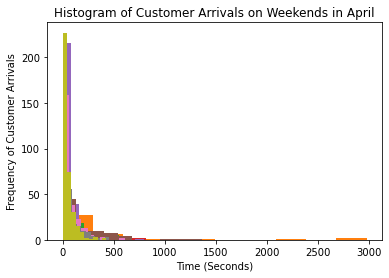

In [176]:
start2 = TimeInterval(IntervalGen(april2_start, "start"))
start3 = TimeInterval(IntervalGen(april3_start, "start"))
start9 = TimeInterval(IntervalGen(april9_start, "start"))
start10 = TimeInterval(IntervalGen(april10_start, "start"))
start16 = TimeInterval(IntervalGen(april16_start, "start"))
start17 = TimeInterval(IntervalGen(april17_start, "start"))
start23 = TimeInterval(IntervalGen(april23_start, "start"))
start24 = TimeInterval(IntervalGen(april24_start, "start"))
start30 = TimeInterval(IntervalGen(april30_start, "start"))

plt.hist(start2)
plt.hist(start3)
plt.hist(start9)
plt.hist(start10)
plt.hist(start16)
plt.hist(start17)
plt.hist(start23)
plt.hist(start24)
plt.hist(start30)
plt.title('Histogram of Customer Arrivals on Weekends in April')
plt.xlabel('Time (Seconds)')
plt.ylabel('Frequency of Customer Arrivals')
plt.show()

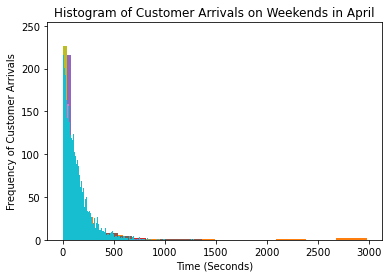

In [300]:
plt.hist(start2)
plt.hist(start3)
plt.hist(start9)
plt.hist(start10)
plt.hist(start16)
plt.hist(start17)
plt.hist(start23)
plt.hist(start24)
plt.hist(start30)
arrival_ivt = [(gen_t(.008)*1.1) for i in range(5000)]
plt.hist(arrival_ivt, bins = 200)
plt.title('Histogram of Customer Arrivals on Weekends in April')
plt.xlabel('Time (Seconds)')
plt.ylabel('Frequency of Customer Arrivals')
plt.show()

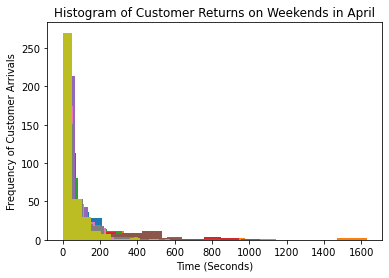

In [270]:
end2 = TimeInterval(IntervalGen(april2_end, 'end'))
end3 = TimeInterval(IntervalGen(april3_end, 'end'))
end9 = TimeInterval(IntervalGen(april9_end, 'end'))
end10 = TimeInterval(IntervalGen(april10_end, 'end'))
end16 = TimeInterval(IntervalGen(april16_end, 'end'))
end17 = TimeInterval(IntervalGen(april17_end, 'end'))
end23 = TimeInterval(IntervalGen(april23_end, 'end'))
end24 = TimeInterval(IntervalGen(april24_end, 'end'))
end30 = TimeInterval(IntervalGen(april30_end, 'end'))

plt.hist(end2)
plt.hist(end3)
plt.hist(end9)
plt.hist(end10)
plt.hist(end16)
plt.hist(end17)
plt.hist(end23)
plt.hist(end24)
plt.hist(end30)
plt.title('Histogram of Customer Returns on Weekends in April')
plt.xlabel('Time (Seconds)')
plt.ylabel('Frequency of Customer Arrivals')
plt.show()

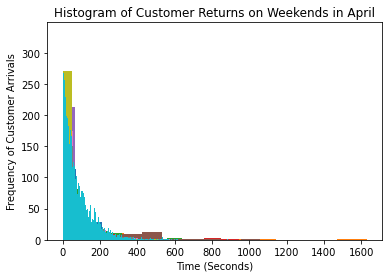

In [297]:
plt.hist(end2)
plt.hist(end3)
plt.hist(end9)
plt.hist(end10)
plt.hist(end16)
plt.hist(end17)
plt.hist(end23)
plt.hist(end24)
plt.hist(end30)
return_ivt = [(gen_t(.015)**1.05) for i in range(5000)]
plt.hist(return_ivt, bins = 200)
plt.title('Histogram of Customer Returns on Weekends in April')
plt.xlabel('Time (Seconds)')
plt.ylabel('Frequency of Customer Arrivals')
plt.show()

a_0: 0
b_0: 711
LL_0: -1300.2011411010417
a: 0.0
b 711.0
LL: -1300.2011411010417


C:\Users\eddie\AppData\Local\Temp/ipykernel_19604/3975242001.py:4: RuntimeWarning: divide by zero encountered in log
  return np.sum(-np.log(stats.uniform.pdf(x, params[0], params[1])))


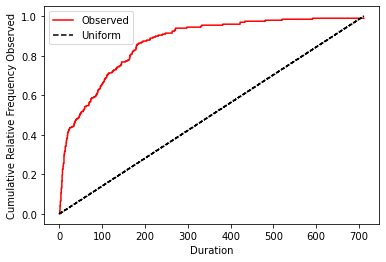

In [213]:
def minus_log_likelihood_uniform(params, x):
    # note: scipy stats uses mu as the first argument and
    # sigma as the second argument for the normal distribution
    return np.sum(-np.log(stats.uniform.pdf(x, params[0], params[1])))

a = np.min(end2)
b = np.max(end2)
#rint(a,b)

# print initial log likelihood
print('a_0:',a)
print('b_0:',b)
print('LL_0:',(-minus_log_likelihood_uniform((a, b), end2)))

# minimize minus log likelihood
results = optimize.minimize(minus_log_likelihood_uniform, x0=(a, b), args=end2, method='Nelder-Mead')

# get optimized values from results
a1 = results.x[0]
b1 = results.x[1]
LL = -results.fun

print('a:',(a1))
print('b',b1)
print('LL:',LL)



# compute cumulative relative frequency
x = np.linspace(0, b,1000)
F_obs = np.array([np.sum(end2 < i)/len(april2_end.index) for i in x])

# plot cumulative relative frequency
plt.figure()
plt.step(x, F_obs, '-r', where='post', label='Observed')
plt.step(x, stats.uniform.cdf(x, a1, b1), '--k', label='Uniform'.format(a1, b1))
plt.xlabel('Duration')
plt.ylabel('Cumulative Relative Frequency Observed')
plt.legend(loc='best')
plt.show()

mu_0: 90.60606060606061
sigma_0: 116.15142559894115
LL_0: -1221.9189866918693
mu: 90.60604613040634
sigma: 115.85777314189326
LL: -1221.9177197981865


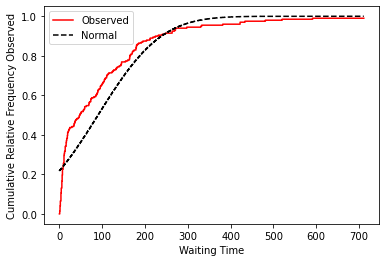

In [216]:
def minus_log_likelihood_normal(params, x):
    # note: scipy stats uses mu as the first argument and
    # sigma as the second argument for the normal distribution
    return np.sum(-np.log(stats.norm.pdf(x, params[0], params[1])))

# initial guesses for model parameters
mu_0 = np.mean(end2)
sigma_0 = np.std(end2, ddof=1)

# print initial log likelihood
print('mu_0:',mu_0)
print('sigma_0:',(sigma_0))
print('LL_0:',(-minus_log_likelihood_normal((mu_0, sigma_0), end2)))

# minimize minus log likelihood
results = optimize.minimize(minus_log_likelihood_normal, x0=(mu_0, sigma_0), args=end2, method='Nelder-Mead')

# get optimized values from results
mu = results.x[0]
sigma = results.x[1]
LL = -results.fun

print('mu:',(mu))
print('sigma:',(sigma))
print('LL:',(LL))

# plot cumulative relative frequency
plt.figure()
plt.step(x, F_obs, '-r', where='post', label='Observed')
plt.step(x, stats.norm.cdf(x, mu, sigma), '--k', label='Normal'.format(mu, sigma))
plt.xlabel('Waiting Time')
plt.ylabel('Cumulative Relative Frequency Observed')
plt.legend(loc='best')
plt.show()

In [307]:
from __future__ import absolute_import, division, print_function
import simpy
import numpy as np
import matplotlib.pyplot as plt

num_runs = 1
# simulation duration (seconds) - 4 hour timespan
sim_duration = 4*60*60
#number of docks at station
num_docks = 0
#number of bikes at start of day
initial_bikes = 0

env = simpy.Environment()

arrival_rate = 0.008
return_rate = 0.015


def generate_arrivals():
    while True:
        inter_arrival_time = np.random.exponential(1/arrival_rate)*1.1
        yield env.timeout(inter_arrival_time)
        print(f"customer arrival at {env.now}")

def generate_returns():
    while True:
        inter_return_time = np.random.exponential(1/return_rate)**1.05
        yield env.timeout(inter_return_time)
        print(f"customer return at {env.now}")

env.process(generate_arrivals())
env.process(generate_returns())
env.run(until=sim_duration)

customer return at 68.36706799344344
customer arrival at 204.0427727333108
customer return at 427.8524329351875
customer arrival at 758.3388980432435
customer arrival at 775.6998313617448
customer return at 865.61454739556
customer return at 887.260717783741
customer return at 936.4475809728979
customer return at 1054.9805568808376
customer return at 1072.3703848557418
customer return at 1140.464439585117
customer return at 1156.0855350496256
customer arrival at 1158.6044265728979
customer return at 1164.2363036463694
customer arrival at 1175.6448470303624
customer arrival at 1176.2863813754007
customer return at 1199.1842120057172
customer arrival at 1252.3419241757292
customer return at 1289.3240289163782
customer return at 1295.8634044499129
customer return at 1300.5067977174585
customer arrival at 1322.967868461542
customer return at 1325.8482151162266
customer arrival at 1348.4743710739592
customer arrival at 1371.0198750138527
customer arrival at 1596.125251483437
customer return